<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
from numpy import genfromtxt
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math

# Obtain Random Data Points

Open the files provided on the website.

In [3]:
kx_RW = genfromtxt('kx_RW.dat', delimiter=' ')
ky_RW = genfromtxt('ky_RW.dat', delimiter=' ')
Omega_RW = genfromtxt('Omega_RW.dat', delimiter=' ')
Omega_RW = Omega_RW.T

In [4]:
KX, KY = np.meshgrid(kx_RW, ky_RW)

Plot the raw data.

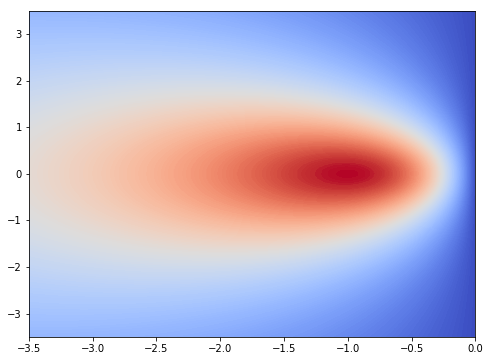

In [5]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

ax.contourf(KX, KY, Omega_RW, 200, cmap=cm.coolwarm)

plt.show()

Select 100 data points at random.

In [6]:
N = 100
iix = np.random.permutation(np.arange(0,len(kx_RW),1))[0:N]
iiy = np.random.permutation(np.arange(0,len(ky_RW),1))[0:N]

kx_sub = kx_RW[iix]
ky_sub = ky_RW[iiy]
Omega_sub = Omega_RW[iiy, iix]

Plot the random data points using a color scheme.

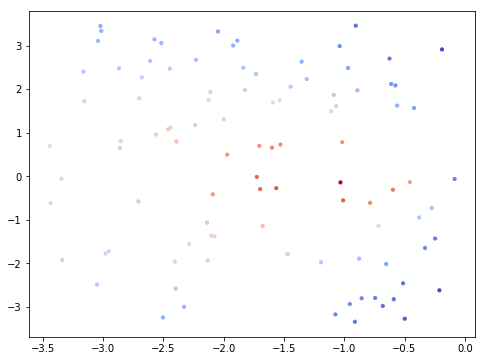

In [7]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

ax.scatter(kx_sub, ky_sub, c=Omega_sub, cmap=cm.coolwarm, s=10)

plt.show()

# Part 1: Global Interpolation

## Define Grid and Required Functions

Create a 100x200 meshgrid that will be used for the interpolation functions.

In [8]:
Nx = 100
Ny = 200

xx_grid = np.linspace(min(kx_RW), max(kx_RW), Nx)
yy_grid = np.linspace(min(ky_RW), max(ky_RW), Ny)
KX_grid, KY_grid = np.meshgrid(xx_grid, yy_grid)

The first function defined below takes in (x, y) coordinates on the meshgrid and returns an appropriate value based on global interpolation. The second function uses the first one over and over again to fill up the entire meshgrid.

In [9]:
def get_global_point(x, y, func, **params):
    point =0
    for i, val in enumerate(Omega_sub):
        r_sq = (x-kx_sub[i])**2+(y-ky_sub[i])**2
        point += func(r_sq, **params)*val
    return point

def global_interp(xx_grid, yy_grid, func, **params):
    
    Omega_globe = np.zeros((len(yy_grid), len(xx_grid)))
    for (ix, x) in enumerate(xx_grid):
        for (iy, y) in enumerate(yy_grid):
            Omega_globe[iy][ix]=get_global_point(x, y, func, **params)
    
    return Omega_globe

## Exponential Decay

We use a weighted a function defined as 

$$w(r) = e^{-r^2/2\sigma^2} $$

In [10]:
def exp_decay(r_sq, sigma):
    return np.exp((-r_sq)/(2*sigma)**2)

Obtain interpolations based on different values of $\sigma$.

In [11]:
globe_interp_1 = global_interp(xx_grid, yy_grid, exp_decay, sigma=0.25)
globe_interp_2 = global_interp(xx_grid, yy_grid, exp_decay, sigma=0.5)
globe_interp_3 = global_interp(xx_grid, yy_grid, exp_decay, sigma=0.75)
globe_interp_4 = global_interp(xx_grid, yy_grid, exp_decay, sigma=1)

globes = [globe_interp_1, globe_interp_2, globe_interp_3, globe_interp_4]

Produce a plot.

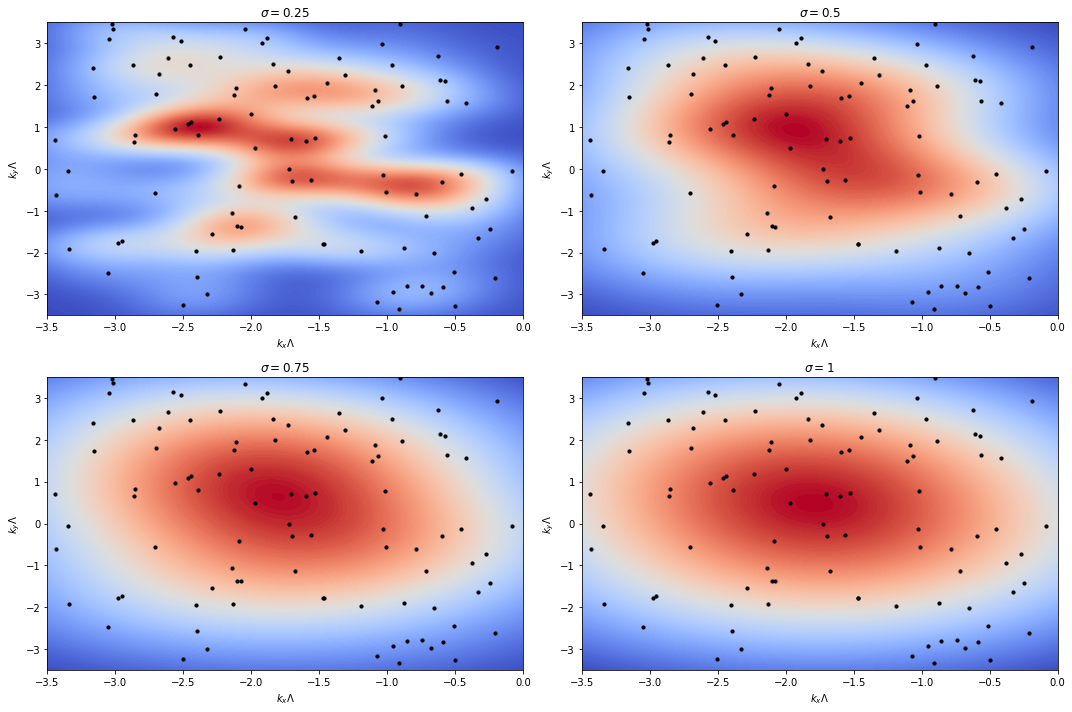

In [12]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,10))

axs = [ax0, ax1, ax2, ax3]

for ax, globe in zip(axs, globes):

    ax.contourf(KX_grid, KY_grid, globe, 200, cmap=cm.coolwarm)
    ax.scatter(kx_sub, ky_sub, s=10, c='k')
  
    ax.set_xlabel('$k_x \Lambda$')
    ax.set_ylabel('$k_y \Lambda$')

    ax.set_xlim(-3.5, 0)
    ax.set_ylim(-3.5, 3.5)

ax0.set_title('$\sigma=0.25$')
ax1.set_title('$\sigma=0.5$')
ax2.set_title('$\sigma=0.75$')
ax3.set_title('$\sigma=1$')

fig.tight_layout()
plt.show()

In [13]:
print('sigma = 0.25 yields a max value of {}'.format(np.amax(globe_interp_1)))
print('sigma = 0.5 yields a max value of {}'.format(np.amax(globe_interp_2)))
print('sigma = 0.75 yields a max value of {}'.format(np.amax(globe_interp_3)))
print('sigma = 1 yields a max value of {}'.format(np.amax(globe_interp_4)))
print('The true max value is {}'.format(np.amax(Omega_RW)))

sigma = 0.25 yields a max value of 5.131334356013366e-05
sigma = 0.5 yields a max value of 0.00013327773971534622
sigma = 0.75 yields a max value of 0.0002296270865654942
sigma = 1 yields a max value of 0.00031460728797046264
The true max value is 1.4e-05


The maximum values are now greater than the original maximum value! This has occured because the contribution from weighting the surrounding points occasionally exceeds the value at that point.

## Inverse Squared Distance

Note that the weighted function $1/r^2$ diverges when $r=0$ so we can't use it- this is the one you showed in class. Literature online suggests using the weighted function

$$w(r) = \frac{1}{1+Ar^2} $$

and plot the result for different values of $A$.

In [14]:
def inv_dist_decay(r_sq, A):
    return 1/(1+A*r_sq)

Obtain interpolations for different values of $A$.

In [15]:
KX_grid, KY_globe = np.meshgrid(xx_grid, yy_grid)
globe_interp_1 = global_interp(xx_grid, yy_grid, inv_dist_decay, A=5)
globe_interp_2 = global_interp(xx_grid, yy_grid, inv_dist_decay, A=4)
globe_interp_3 = global_interp(xx_grid, yy_grid, inv_dist_decay, A=3)
globe_interp_4 = global_interp(xx_grid, yy_grid, inv_dist_decay, A=2)

globes = [globe_interp_1, globe_interp_2, globe_interp_3, globe_interp_4]

Produce a plot.

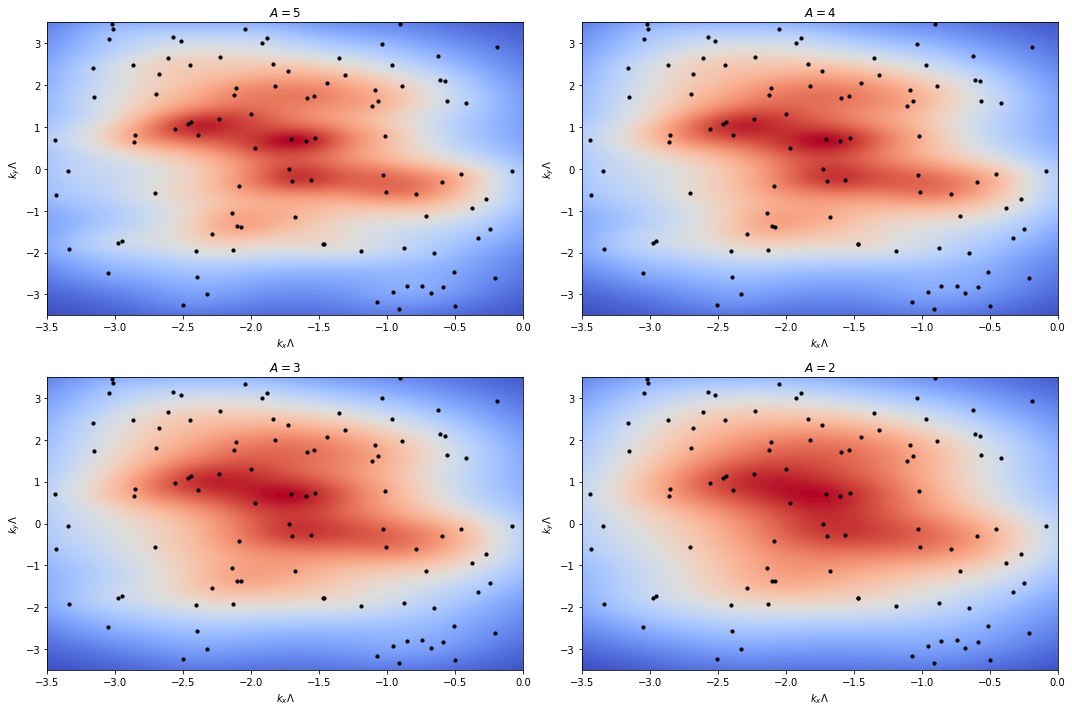

In [16]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,10))

axs = [ax0, ax1, ax2, ax3]

for ax, globe in zip(axs, globes):

    ax.contourf(KX_grid, KY_grid, globe, 200, cmap=cm.coolwarm)
    ax.scatter(kx_sub, ky_sub, s=10, c='k')
  
    ax.set_xlabel('$k_x \Lambda$')
    ax.set_ylabel('$k_y \Lambda$')

    ax.set_xlim(-3.5, 0)
    ax.set_ylim(-3.5, 3.5)

ax0.set_title('$A=5$')
ax1.set_title('$A=4$')
ax2.set_title('$A=3$')
ax3.set_title('$A=2$')

fig.tight_layout()
plt.show()

In [17]:
print('A = 0.25 yields a max value of {}'.format(np.amax(globe_interp_1)))
print('A = 0.5 yields a max value of {}'.format(np.amax(globe_interp_2)))
print('A = 0.75 yields a max value of {}'.format(np.amax(globe_interp_3)))
print('A = 1 yields a max value of {}'.format(np.amax(globe_interp_4)))
print('The true max value is {}'.format(np.amax(Omega_RW)))

A = 0.25 yields a max value of 9.10650652554283e-05
A = 0.5 yields a max value of 0.00010274904401529861
A = 0.75 yields a max value of 0.00012028178269352736
A = 1 yields a max value of 0.0001498682115962676
The true max value is 1.4e-05


The true maximum value is less than that of the interpolated data sets.

## Advantages and Disadvantages

As you'll see below, the local methods perform much better than the global methods for this data set. There are, however, a few things worth discussing for the global interpolation methods. While larger $A$ and smaller $\sigma$ tend to produce higher resolution plots, they also tend to predict blue areas in the central region that are inconsistent with the original data set, The smaller $A$ and larger $\sigma$ tend to smooth the region more, producing less resolution (more weight from all the surrounding points) but an image more closely related to the actual data.

# Part 2: Local Methods

As you'll see below, the local interpolation methods work much better than the global ones.

In [18]:
points = np.array(list(zip(kx_sub,ky_sub)))

Obtain a nearest neighbour, linear, and cubic interpolation. PYTHON does not currently support natural neighbour in Scipy (they removed it from a previous version). They instead have replaced it with cubic interpolation, which (as you'll see), works marvelously. I'll crank down the number of data points later on and you can see how well it compares to the mentioned natural neighbour method.

In [19]:
Omega_nearest = griddata(points, Omega_sub, (KX_grid, KY_grid), method='nearest')
Omega_linear = griddata(points, Omega_sub, (KX_grid, KY_grid), method='linear')
Omega_cubic = griddata(points, Omega_sub, (KX_grid, KY_grid), method='cubic')

## Nearest Neighbour

Nearest Neighbour Plot

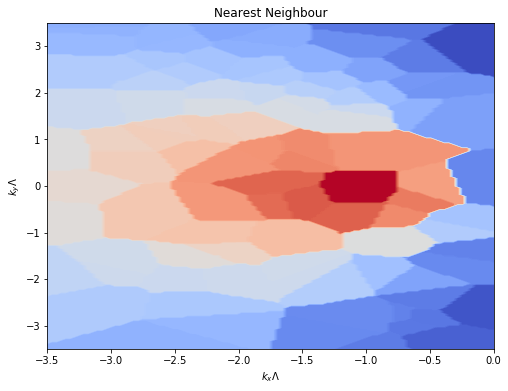

In [20]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

ax.contourf(KX_grid, KY_grid, Omega_nearest, 200, cmap=cm.coolwarm)
ax.set_xlabel('$k_x \Lambda$')
ax.set_ylabel('$k_y \Lambda$')
ax.set_title('Nearest Neighbour')

plt.show()

## Linear

Linear Interpolation Plot.

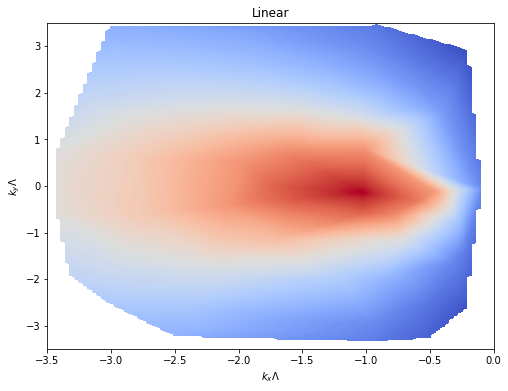

In [21]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

ax.contourf(KX_grid, KY_grid, Omega_linear, 200, cmap=cm.coolwarm)
ax.set_xlabel('$k_x \Lambda$')
ax.set_ylabel('$k_y \Lambda$')
ax.set_title('Linear')


plt.show()

## Cubic

Cubic Interpolation Plot. (Looks pretty nice!)

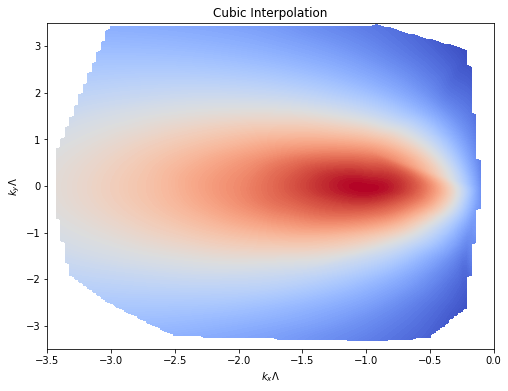

In [22]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()

ax.contourf(KX_grid, KY_grid, Omega_cubic, 200, cmap=cm.coolwarm)
ax.set_xlabel('$k_x \Lambda$')
ax.set_ylabel('$k_y \Lambda$')
ax.set_title('Cubic Interpolation')

plt.show()

The cubic plot clearly produces the most accurate plot **for this particular data set** possibly because it has a tendency to smooth the data. For noiser data sets with higher spacial frequencies, perhaps the cubic interpolation would provide a worse fit. The nearest neighbour is not a good interpolation at all, and in this case, the linear interpolation appears to have more abrupt changes in the 1st spacial derivatives.

## Less and Less Data Points

50 random points...

In [23]:
N = 50
iix = np.random.permutation(np.arange(0,len(kx_RW),1))[0:N]
iiy = np.random.permutation(np.arange(0,len(ky_RW),1))[0:N]

kx_sub = kx_RW[iix]
ky_sub = ky_RW[iiy]
Omega_sub = Omega_RW[iiy, iix]
points = np.array(list(zip(kx_sub,ky_sub)))

In [24]:
Omega_nearest = griddata(points, Omega_sub, (KX_grid, KY_grid), method='nearest')
Omega_linear = griddata(points, Omega_sub, (KX_grid, KY_grid), method='linear')
Omega_cubic = griddata(points, Omega_sub, (KX_grid, KY_grid), method='cubic')

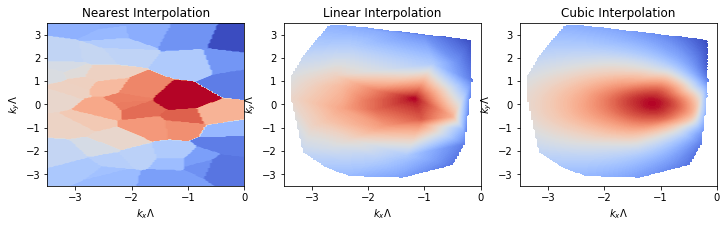

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

ax[0].contourf(KX_grid, KY_grid, Omega_nearest, 200, cmap=cm.coolwarm)
ax[0].set_xlabel('$k_x \Lambda$')
ax[0].set_ylabel('$k_y \Lambda$')
ax[0].set_title('Nearest Interpolation')

ax[1].contourf(KX_grid, KY_grid, Omega_linear, 200, cmap=cm.coolwarm)
ax[1].set_xlabel('$k_x \Lambda$')
ax[1].set_ylabel('$k_y \Lambda$')
ax[1].set_title('Linear Interpolation')

ax[2].contourf(KX_grid, KY_grid, Omega_cubic, 200, cmap=cm.coolwarm)
ax[2].set_xlabel('$k_x \Lambda$')
ax[2].set_ylabel('$k_y \Lambda$')
ax[2].set_title('Cubic Interpolation')

plt.show()

25 random points!

In [26]:
N = 25
iix = np.random.permutation(np.arange(0,len(kx_RW),1))[0:N]
iiy = np.random.permutation(np.arange(0,len(ky_RW),1))[0:N]

kx_sub = kx_RW[iix]
ky_sub = ky_RW[iiy]
Omega_sub = Omega_RW[iiy, iix]
points = np.array(list(zip(kx_sub,ky_sub)))

In [27]:
Omega_nearest = griddata(points, Omega_sub, (KX_grid, KY_grid), method='nearest')
Omega_linear = griddata(points, Omega_sub, (KX_grid, KY_grid), method='linear')
Omega_cubic = griddata(points, Omega_sub, (KX_grid, KY_grid), method='cubic')

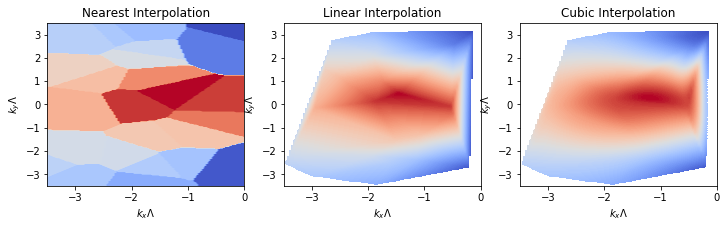

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

ax[0].contourf(KX_grid, KY_grid, Omega_nearest, 200, cmap=cm.coolwarm)
ax[0].set_xlabel('$k_x \Lambda$')
ax[0].set_ylabel('$k_y \Lambda$')
ax[0].set_title('Nearest Interpolation')

ax[1].contourf(KX_grid, KY_grid, Omega_linear, 200, cmap=cm.coolwarm)
ax[1].set_xlabel('$k_x \Lambda$')
ax[1].set_ylabel('$k_y \Lambda$')
ax[1].set_title('Linear Interpolation')

ax[2].contourf(KX_grid, KY_grid, Omega_cubic, 200, cmap=cm.coolwarm)
ax[2].set_xlabel('$k_x \Lambda$')
ax[2].set_ylabel('$k_y \Lambda$')
ax[2].set_title('Cubic Interpolation')

plt.show()

But wait. Can  we do better? 10 random data points?? This will probably work so long as they are disperesed properly throughout the region.

In [29]:
N = 10
iix = np.random.permutation(np.arange(0,len(kx_RW),1))[0:N]
iiy = np.random.permutation(np.arange(0,len(ky_RW),1))[0:N]

kx_sub = kx_RW[iix]
ky_sub = ky_RW[iiy]
Omega_sub = Omega_RW[iiy, iix]
points = np.array(list(zip(kx_sub,ky_sub)))

In [30]:
Omega_nearest = griddata(points, Omega_sub, (KX_grid, KY_grid), method='nearest')
Omega_linear = griddata(points, Omega_sub, (KX_grid, KY_grid), method='linear')
Omega_cubic = griddata(points, Omega_sub, (KX_grid, KY_grid), method='cubic')

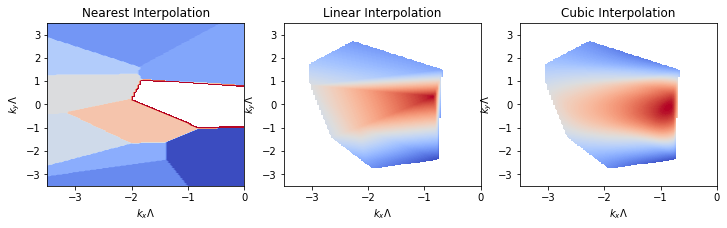

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))

ax[0].contourf(KX_grid, KY_grid, Omega_nearest, 200, cmap=cm.coolwarm)
ax[0].set_xlabel('$k_x \Lambda$')
ax[0].set_ylabel('$k_y \Lambda$')
ax[0].set_title('Nearest Interpolation')

ax[1].contourf(KX_grid, KY_grid, Omega_linear, 200, cmap=cm.coolwarm)
ax[1].set_xlabel('$k_x \Lambda$')
ax[1].set_ylabel('$k_y \Lambda$')
ax[1].set_title('Linear Interpolation')

ax[2].contourf(KX_grid, KY_grid, Omega_cubic, 200, cmap=cm.coolwarm)
ax[2].set_xlabel('$k_x \Lambda$')
ax[2].set_ylabel('$k_y \Lambda$')
ax[2].set_title('Cubic Interpolation')

plt.show()

At this point we are't properly sampling the region.